# Workbook for Processing the P2FA forced alignment
By Katrina Li 2023.4.27

# Outline
1. Check the boundary

    Use `Check_P2FA.praat`

1. Modify the onset-rhyme boudnary

    Use `modify_boundaries.praat`

1. Generate the f0 tier

1. Modify the f0 boundary

1. Extract f0 and duration

    Use `extract_acoustics.py` (cf. InTone_Visualisation)


1. Check Visualitaion, mostly f0 data

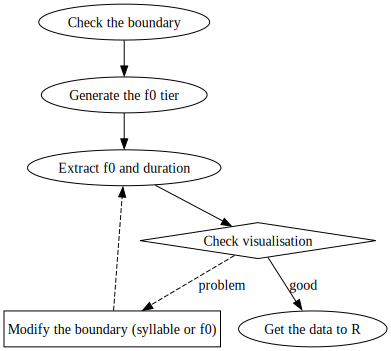

In [17]:
from graphviz import Digraph
dot = Digraph(comment = 'Outline')
dot.node("CheckB","Check the boundary")
dot.node("Modify","Modify the boundary (syllable or f0)",shape = "box")
dot.node("Generatef0","Generate the f0 tier")
dot.node("Extract","Extract f0 and duration")
dot.node("Check","Check visualisation",shape = "diamond")
dot.node("Finish","Get the data to R")
# connections
dot.edge("CheckB","Generatef0")
dot.edge("Generatef0", "Extract")
# dot.edge("Generatef0", "Modifyf0")
dot.edge("Modify","Extract",style = "dashed")
dot.edge("Extract","Check")
dot.edge("Check","Finish",label = "good")
dot.edge("Check","Modify",label = "problem", style = "dashed")
dot

## Modify the boundary (f0 or syllable)

Put the files in the `/modify` folder, which can either be in `textgrid_checked` folder to modify onset-syllable boundarieds), or in `textgrid_pitch_batch` folder to modify the f0 boundaries.

Run the praat script `modify_boundaries.praat`, the go through the files in a folder



**Log:**

Changsha: the previous standard is a bit loose.

- add /j/ as an onset: 英，耶
- check the ending; also other boundaries in general
Next:
- iow instead of io - it's OK that this does not change!

Note for analysis Changsha:
- if there is SFP, then duration shall be excluded
- some in-sentence-adding is less sever, like 一杂杂，一杂
- but pay attention to the word following the noun - it can be a phrasing cue, e.g. 小英呐

- To delete: Changsha S10diaN1C1, S10diaN1D1
- S15diaN1系列 missing？

## Generate the f0 tier
The code below will call the praat script 'generate_f0_tier.praat', replace the rhyme tier to slightly modified f0 tiers.

In [12]:
# This file will read specified files, and run the praat script
import subprocess
from itertools import product
import os
import shutil
import parselmouth
from parselmouth.praat import call
import math
par = ["S9"]
dia = ["dia", "diaN", "diaN1"]
sentence = ["C","D"]
focus = ["1","2","5"]
element_list = list(product(par,dia,sentence,focus))
current_lang = "Changsha"
dir = os.path.join("/Users/kechun/Documents/0_PhD_working_folder", str(current_lang), "workflow")
directory = os.path.join(dir, "textgrid_checked")
destination = os.path.join(dir, "textgrid_checked/processed")
# Open the sound
directory_sound = os.path.join(dir, "sound_original")

# Argument to the script
# The first three is to call the app and script
# Arg1: filename
# Arg2: textgriddir
# Arg3: sounddir
# Arg2: f0min (if 0, then the default two-pass pitch range calculation will be used)
# Arg3: f0max (if 0, then the default two-pass pitch range calculatio will be used)
# Other variables like file directory, the tiers can be modified
# Output: the updated f0 
for element in element_list:
    fullname = ''.join(element)
    filename = fullname + "_checked"
    # Open the sound
    soundname = os.path.join(directory_sound, fullname + ".wav")
    sound = parselmouth.Sound(soundname)
    # Calculate the best f0
    # The first pass
    pitch1 = call(sound, "To Pitch", 0.0, 50, 800)
    min1 = call(pitch1, "Get minimum", 0, 0, "Hertz", "None")
    max1 = call(pitch1, "Get maximum", 0, 0, "Hertz", "None")
    q1 = call(pitch1, "Get quantile", 0, 0, 0.25, "Hertz")
    q3 = call(pitch1, "Get quantile", 0, 0, 0.75, "Hertz")
    q1 = math.floor(q1)
    q3 = math.ceil(q3)
    # The second pass
    defaultf0floor = math.floor((0.7 * q1)/ 10) * 10
    defaultf0ceiling = math.ceil((2.5 * q3)/ 10) * 10
    # Run the script, not send, 
    subprocess.call(["/Applications/Praat.app/Contents/MacOS/Praat", "--run", "generate_f0_tier.praat", filename, directory, directory_sound, str(defaultf0floor),str(defaultf0ceiling)])
    path = filename + ".TextGrid"
    shutil.move(os.path.join(directory,path), destination)

## 